In [1]:
# importing packages

import numpy as np
import os
import time
from dask import dataframe as dd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import vitaldb
import csv
from datetime import datetime, time as datetime_time, timedelta
import glob
import sys
import sklearn.neighbors._base
import vitaldb
import itertools

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 300)

In [3]:
def getRootDir():
    """
    Get root folder directory
    :return: root folder directory
    :rtype: path
    """
    rootdir = os.path.abspath(os.curdir)

    return rootdir
rootdir = getRootDir()
rootdir

'/Users/tselanna/Desktop/Code'

In [4]:
# Import dataset
df = glob.glob(os.path.join(
        rootdir, 'TOSHIBA_HDD/2022_07_15T18_01_25_ANALYSIS_DF_44var.csv'))
df = pd.read_csv(df[0], dtype={"Solar8000/BT": float})

In [6]:
 ids = [1,   88,  133,  135,  230,  238,  329,  459,  476,  489,  517,
        525,  535,  551,  569,  581,  591,  618,  808,  820,  830,  851,
        859,  865,  873,  898,  924,  939,  966, 1086, 1088, 1149, 1156,
       1200, 1207, 1232, 1244, 1259, 1311, 1367, 1379, 1381, 1457, 1461,
       1492, 1494, 1499, 1510, 1567, 1625, 1709, 1743, 1764, 1767, 1792,
       1815, 1819, 1826, 1879, 1923, 1965, 1977, 2003, 2026, 2038, 2045,
       2054, 2078, 2094, 2105, 2107, 2109, 2124, 2190, 2220, 2247, 2248,
       2265, 2278, 2287, 2306, 2316, 2372, 2378, 2448, 2456, 2470, 2491,
       2501, 2531, 2540, 2549, 2559, 2580, 2588, 2617, 2649, 2693, 2773,
       2784, 2813, 2834, 2863, 2886, 2923, 2934, 2957, 3022, 3029, 3039,
       3053, 3062, 3155, 3161, 3180, 3189, 3227, 3250, 3283, 3285, 3310,
       3314, 3343, 3401, 3423, 3431, 3477, 3494, 3496, 3512, 3532, 3604,
       3623, 3639, 3670, 3703, 3704, 3714, 3724, 3728, 3735, 3754, 3761,
       3788, 3808, 3823, 3874, 3918, 3924, 3933, 3943, 3992, 4010, 4110,
       4121, 4158, 4186, 4225, 4354, 4355, 4366, 4458, 4531, 4563, 4607,
       4617, 4626, 4627, 4686, 4691, 4701, 4711, 4729, 4825, 4829, 4888,
       4898, 4909, 4943, 5017, 5020, 5068, 5206, 5221, 5249, 5252, 5284,
       5293, 5318, 5335, 5378, 5400, 5465, 5509, 5540, 5555, 5582, 5601,
       5658, 5716, 5734, 5737, 5741, 5764, 5888, 5949, 6059, 6118, 6123,
       6133, 6181, 6218, 6231, 6232, 6265, 6316, 6321, 6340, 6358, 6385]

In [7]:
len(ids)

220

In [8]:
isin = df.loc[df['caseid'].isin(ids)]

In [9]:
# shrink dataset 
caseids = isin.caseid.unique()
caseids


array([   1,   88,  133,  135,  230,  238,  329,  459,  476,  489,  517,
        525,  535,  551,  569,  581,  591,  618,  808,  820,  830,  851,
        859,  865,  873,  898,  924,  939,  966, 1086, 1088, 1149, 1156,
       1200, 1207, 1232, 1244, 1259, 1311, 1367, 1379, 1381, 1457, 1461,
       1492, 1494, 1499, 1510, 1567, 1625, 1709, 1743, 1764, 1767, 1792,
       1815, 1819, 1826, 1879, 1923, 1965, 1977, 2003, 2026, 2038, 2045,
       2054, 2078, 2094, 2105, 2107, 2109, 2124, 2190, 2220, 2247, 2248,
       2265, 2278, 2287, 2306, 2316, 2372, 2378, 2448, 2456, 2470, 2491,
       2501, 2531, 2540, 2549, 2559, 2580, 2588, 2617, 2649, 2693, 2773,
       2784, 2813, 2834, 2863, 2886, 2923, 2934, 2957, 3022, 3029, 3039,
       3053, 3062, 3155, 3161, 3180, 3189, 3227, 3250, 3283, 3285, 3310,
       3314, 3343, 3401, 3423, 3431, 3477, 3494, 3496, 3512, 3532, 3604,
       3623, 3639, 3670, 3703, 3704, 3714, 3724, 3728, 3735, 3754, 3761,
       3788, 3808, 3823, 3874, 3918, 3924, 3933, 39

In [10]:
# only keep MBP variable
data = isin[["Solar8000/NIBP_MBP", 'caseid']].copy()

## Preprocessing

In [20]:
MINUTES_AHEAD = 5  # Predict hypotension 5 minutes ahead
LSTM_NODES = 16  # Number of cells in LSTM
BATCH_SIZE = 100  # Batch size for learning
MAX_CASES = 600  # Maximum number of cases for this example

In [21]:
# Final dataset for training and testing the model
x = []  # input with shape of (segements, timepoints)
y = []  # output with shape of (segments)
valid_mask = []  # validity of each segement
c = []  # caseid of each segment

# maximum number of cases
for caseid in caseids:
    print(f'loading {caseid}', end='...', flush=True)

    # read the mean blood pressure 

    a = data.loc[data.caseid.eq(caseid)]
    b = a[['Solar8000/NIBP_MBP']].values.tolist()
    mbps= list(itertools.chain.from_iterable(b))
    

    # removing the nan values at the beginning and the ending
    case_valid_mask = ~np.isnan(mbps)
    case_sample = 0
    case_event = 0
    for i in range(0, len(mbps) - (300 + MINUTES_AHEAD * 30 + 30)):
        segx = mbps[i:i + 300]
        segy = mbps[i + 300 + MINUTES_AHEAD * 30:i + 300 + MINUTES_AHEAD * 30 + 30]
        
        valid = True
        valid_mask.append(valid)
        evt = np.nanmax(segy) < 65
        x.append(segx)
        y.append(evt)
        c.append(caseid)
        
        if evt:
            case_event += 1
   
        if valid:
            case_sample += 1
            if evt:
                case_event += 1
    
    if case_sample > 0:
        print("{} samples {} ({:.1f} %) events".format(case_sample, case_event, 100*case_event/case_sample))
    else:
        print('no samples')

    if len(np.unique(c)) >= MAX_CASES:
        break

# final caseids
caseids = np.unique(c)

x = np.array(x)
y = np.array(y) 
valid_mask = np.array(valid_mask)
c = np.array(c)

# forward filling
x = pd.DataFrame(x).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values

x = x[...,None]  # add 3rd axis for input of LSTM

print(x.shape)
print(y.shape)

loading 1...no samples
loading 88...3229 samples 0 (0.0 %) events
loading 133...4500 samples 564 (12.5 %) events
loading 135...1521 samples 824 (54.2 %) events
loading 230...1944 samples 1044 (53.7 %) events
loading 238...5293 samples 0 (0.0 %) events
loading 329...3664 samples 0 (0.0 %) events
loading 459...4824 samples 0 (0.0 %) events
loading 476...2235 samples 0 (0.0 %) events
loading 489...2789 samples 174 (6.2 %) events
loading 517...7059 samples 250 (3.5 %) events
loading 525...8791 samples 2144 (24.4 %) events
loading 535...798 samples 0 (0.0 %) events
loading 551...1387 samples 196 (14.1 %) events
loading 569...3682 samples 466 (12.7 %) events
loading 581...6900 samples 0 (0.0 %) events
loading 591...3093 samples 570 (18.4 %) events
loading 618...5162 samples 2046 (39.6 %) events
loading 808...2348 samples 0 (0.0 %) events
loading 820...3158 samples 508 (16.1 %) events
loading 830...984 samples 0 (0.0 %) events
loading 851...2055 samples 718 (34.9 %) events
loading 859...1924 

## Splitting samples into training and testing dataset

In [22]:
ncase = len(caseids)
ntest = int(ncase * 0.2)
ntrain = ncase - ntest
caseids_train = caseids[:ntrain]
caseids_test = caseids[ncase - ntest:ncase]

# train set test set 
train_mask = np.isin(c, caseids_train)
test_mask = np.isin(c, caseids_test)

# invalid samples in test dataset is also needed for plotting
test_x = x[test_mask]
test_y = y[test_mask]
test_c = c[test_mask]

# only valid samples are required for the training dataset
train_x_valid = x[train_mask]
train_y_valid = y[train_mask]
test_x_valid = x[test_mask]
test_y_valid = y[test_mask]

testname = '{}cases {}ahead batchsize={} total {}, train {} ({} events {:.1f}%), test {} ({} events {:.1f}%)'.format(MAX_CASES, MINUTES_AHEAD, BATCH_SIZE, len(y), len(train_y_valid), sum(train_y_valid), 100*np.mean(train_y_valid), len(test_y_valid), sum(test_y_valid), 100*np.mean(test_y_valid))
testname

'600cases 5ahead batchsize=100 total 738080, train 576986 (44988 events 7.8%), test 161094 (10204 events 6.3%)'

## Model building and training

In [23]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Dense, LSTM, Input, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [24]:
# making output folder
tempdir = 'output'
if not os.path.exists(tempdir):
    os.mkdir(tempdir)
weight_path = tempdir + "/weights.hdf5"

# build a model
model = Sequential()
model.add(LSTM(LSTM_NODES, input_shape=x.shape[1:]))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC()])
hist = model.fit(train_x_valid, train_y_valid, validation_split=0.1, epochs=100, batch_size=BATCH_SIZE, class_weight={0:1, 1:5},
                 callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                            EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')])

# reload the best model
model.load_weights(weight_path)
open(tempdir + "/model.json", "wt").write(model.to_json())

Epoch 1/100
5193/5193 [==============================] - ETA: 0s - loss: 0.5727 - accuracy: 0.8701 - auc_1: 0.8554
Epoch 1: val_loss improved from inf to 0.16331, saving model to output/weights.hdf5
5193/5193 [==============================] - 535s 103ms/step - loss: 0.5727 - accuracy: 0.8701 - auc_1: 0.8554 - val_loss: 0.1633 - val_accuracy: 0.9470 - val_auc_1: 0.8488
Epoch 2/100
5193/5193 [==============================] - ETA: 0s - loss: 0.5668 - accuracy: 0.8725 - auc_1: 0.8578
Epoch 2: val_loss improved from 0.16331 to 0.15802, saving model to output/weights.hdf5
5193/5193 [==============================] - 1192s 230ms/step - loss: 0.5668 - accuracy: 0.8725 - auc_1: 0.8578 - val_loss: 0.1580 - val_accuracy: 0.9477 - val_auc_1: 0.8456
Epoch 3/100
5193/5193 [==============================] - ETA: 0s - loss: 0.5644 - accuracy: 0.8696 - auc_1: 0.8578
Epoch 3: val_loss did not improve from 0.15802
5193/5193 [==============================] - 693s 133ms/step - loss: 0.5644 - accuracy: 0

2137

## Evaluation of the model performance

In [25]:
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve

In [26]:
# make prediction on the test dataset
test_y_pred = model.predict(test_x_valid).flatten()

precision, recall, thmbps = precision_recall_curve(test_y_valid, test_y_pred)
auprc = auc(recall, precision)

fpr, tpr, thmbps = roc_curve(test_y_valid, test_y_pred)
auroc = auc(fpr, tpr)

thval = 0.5
f1 = f1_score(test_y_valid, test_y_pred > thval)
acc = accuracy_score(test_y_valid, test_y_pred > thval)
tn, fp, fn, tp = confusion_matrix(test_y_valid, test_y_pred > thval).ravel()

testres = 'auroc={:.3f}, auprc={:.3f} acc={:.3f}, F1={:.3f}, PPV={:.1f}, NPV={:.1f}, TN={}, fp={}, fn={}, TP={}'.format(auroc, auprc, acc, f1, tp/(tp+fp)*100, tn/(tn+fn)*100, tn, fp, fn, tp)
print(testres)



5035/5035 [==============================] - 122s 24ms/step
auroc=0.822, auprc=0.254 acc=0.925, F1=0.242, PPV=33.4, NPV=94.7, TN=147039, fp=3851, fn=8270, TP=1934


In [27]:
auroc

0.8219499839304433

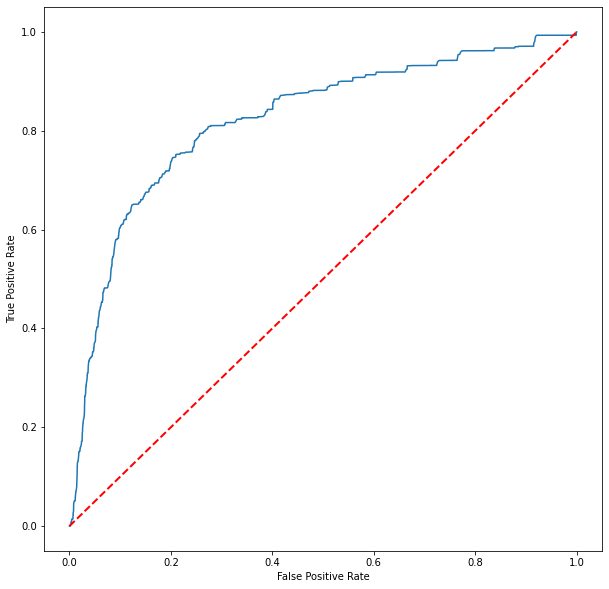

<function matplotlib.pyplot.show(close=None, block=None)>

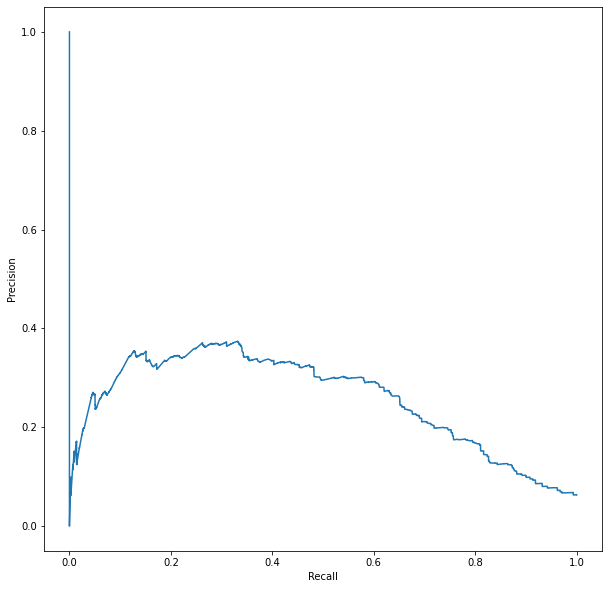

In [28]:
# auroc curve
plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.savefig('{}/auroc.png'.format(tempdir))
# plt.close()
plt.show()

# auprc curve
plt.figure(figsize=(10, 10))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
#plt.savefig('{}/auprc.png'.format(tempdir))
# plt.close()
plt.show


## Plotting each case in the test dataset

213/213 [==============================] - 5s 21ms/step
Print error: 4909	0.05630831617815538	


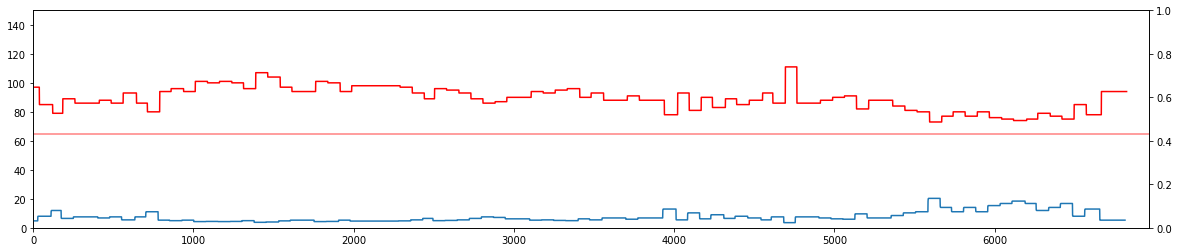

35/35 [==============================] - 1s 27ms/step
Print error: 4943	0.06039520656199995	


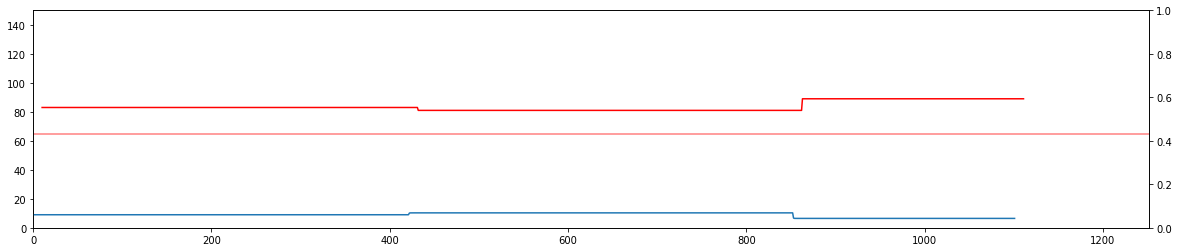

112/112 [==============================] - 3s 25ms/step
Print error: 5017	0.2783614546499795	


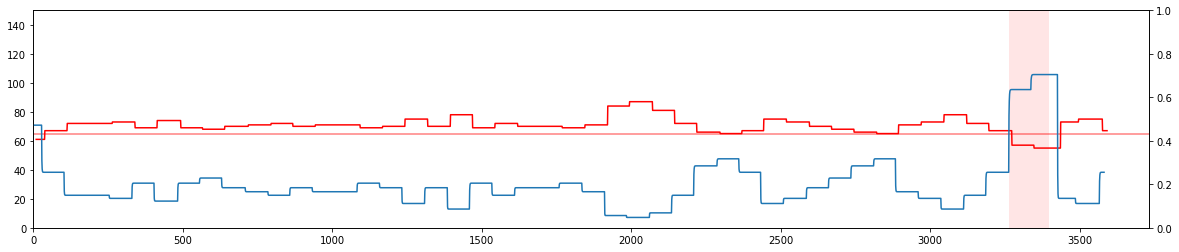

142/142 [==============================] - 3s 21ms/step
Print error: 5020	0.2377132383935969	


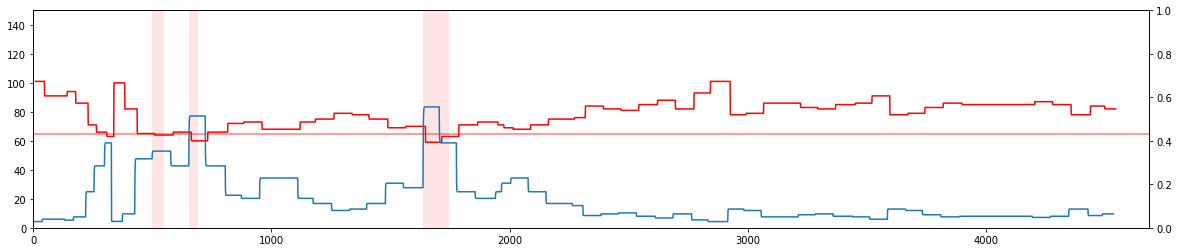

38/38 [==============================] - 1s 24ms/step
Print error: 5068	0.06555433286016991	


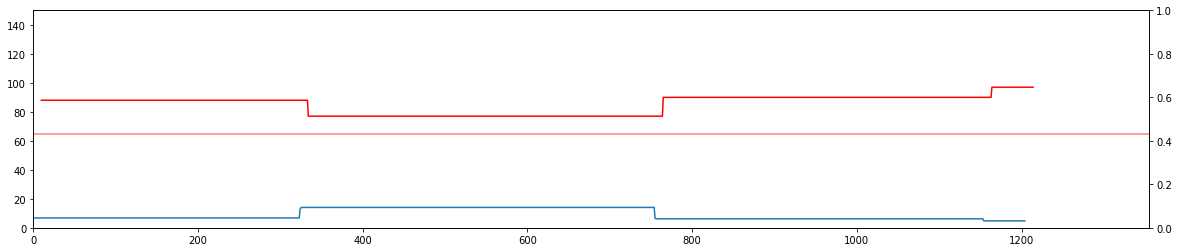

108/108 [==============================] - 3s 25ms/step
Print error: 5206	0.07234652282702782	


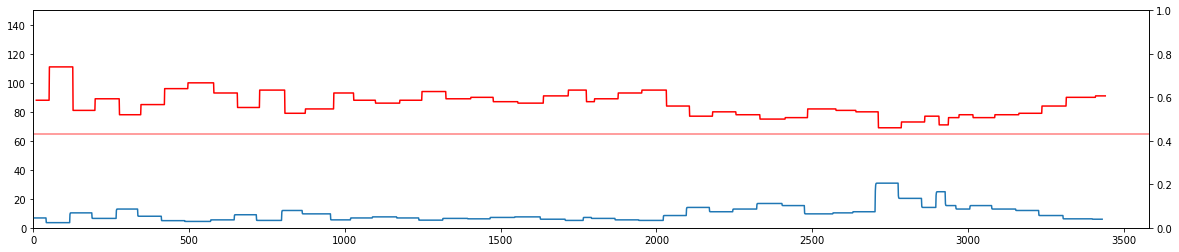

5/5 [==============================] - 0s 26ms/step
Print error: 5221	0.023050924931310942	


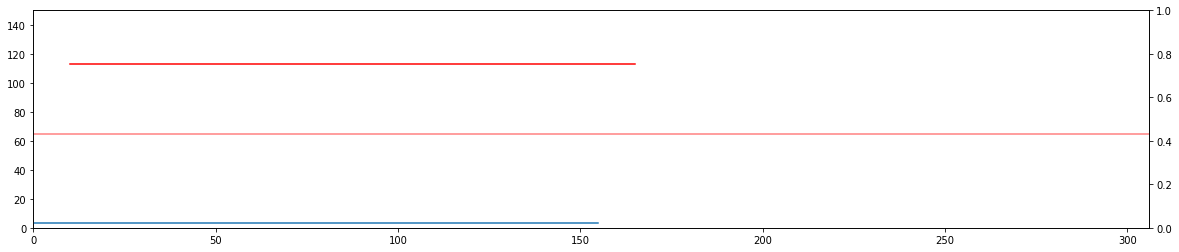

112/112 [==============================] - 3s 25ms/step
Print error: 5249	0.3606859222136992	


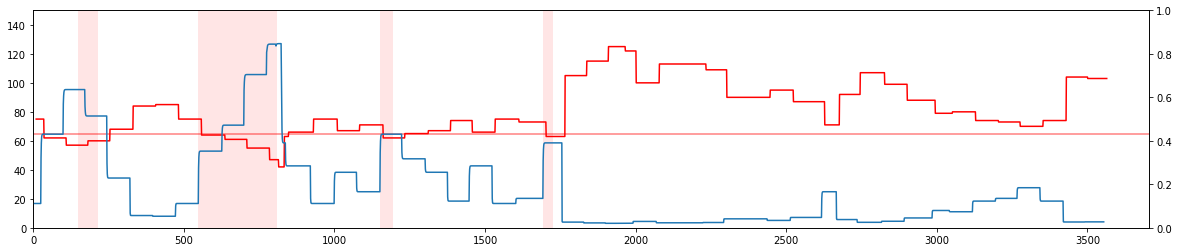

148/148 [==============================] - 3s 19ms/step
Print error: 5252	0.3094643974225383	


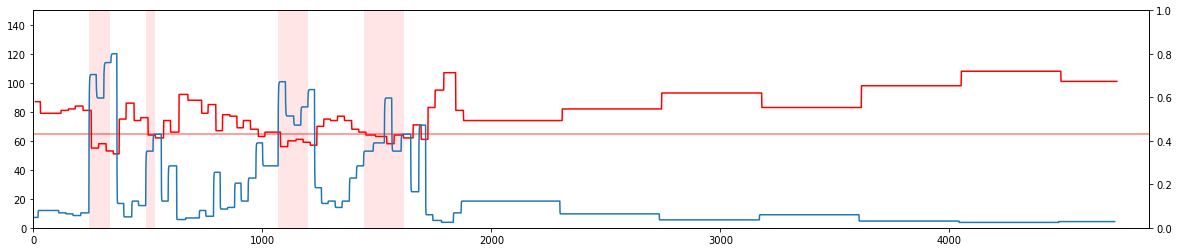

123/123 [==============================] - 3s 20ms/step
Print error: 5284	0.3807966914311698	


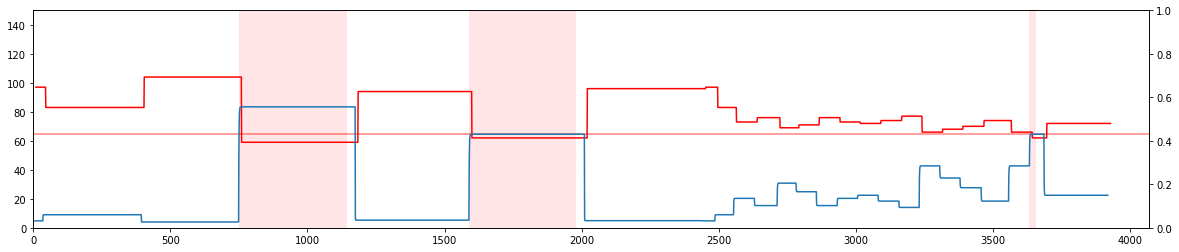

35/35 [==============================] - 1s 29ms/step
Print error: 5293	0.4938287165221377	


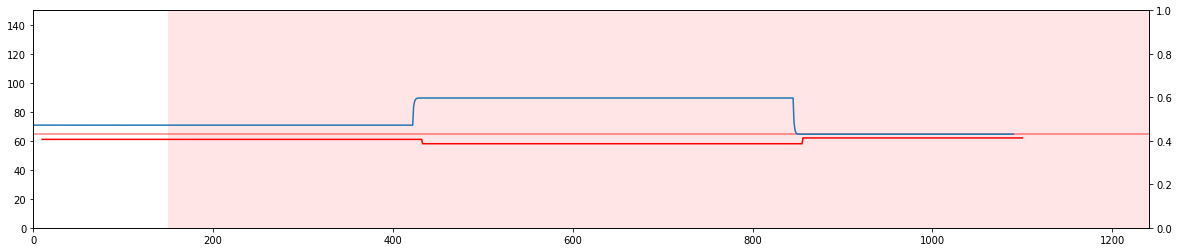

189/189 [==============================] - 4s 23ms/step
Print error: 5318	0.3366147577736944	


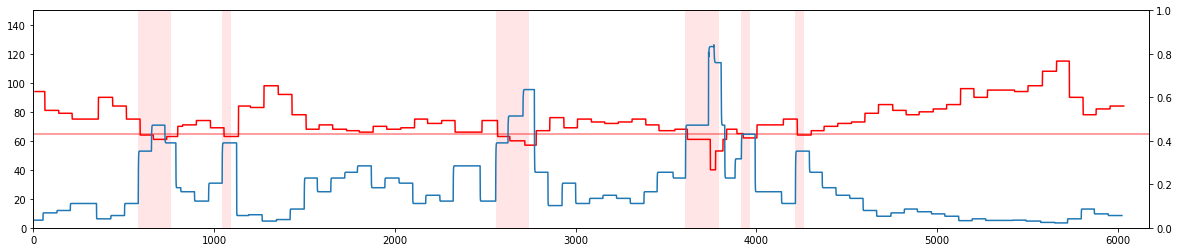

241/241 [==============================] - 6s 25ms/step
Print error: 5335	0.18378941275454802	


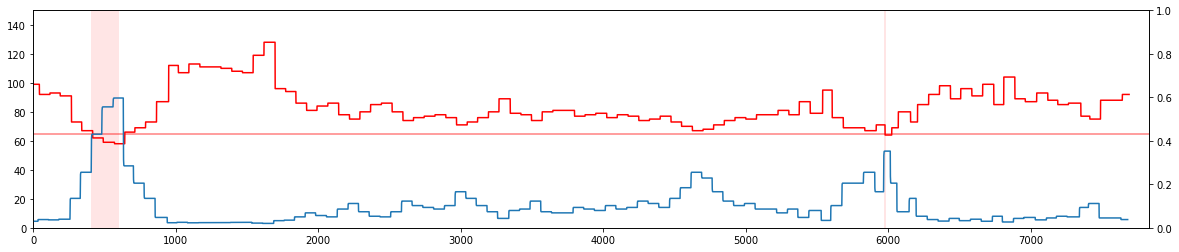

107/107 [==============================] - 3s 27ms/step
Print error: 5378	0.04220788747844858	


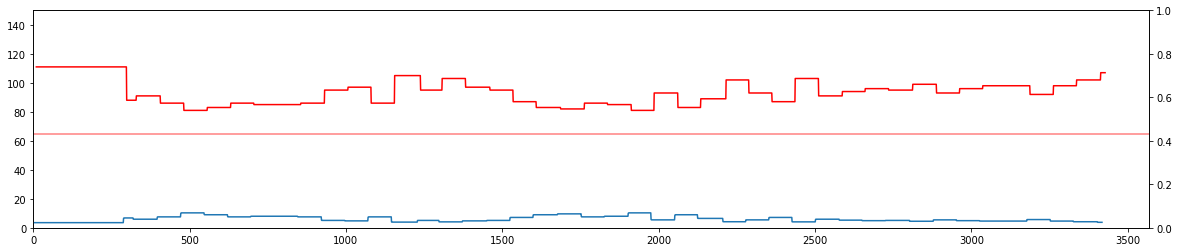

257/257 [==============================] - 7s 25ms/step
Print error: 5400	0.22354426567478264	


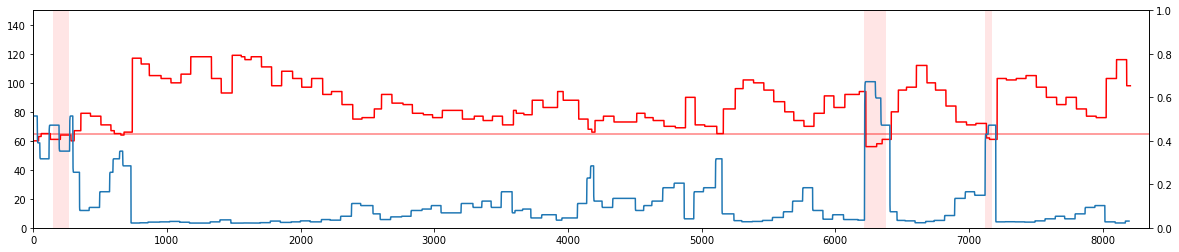

181/181 [==============================] - 5s 25ms/step
Print error: 5465	0.23286890268354843	


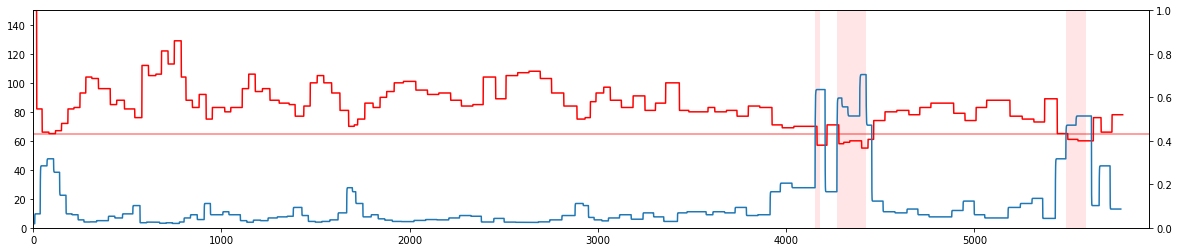

57/57 [==============================] - 2s 29ms/step
Print error: 5509	0.04916802594905953	


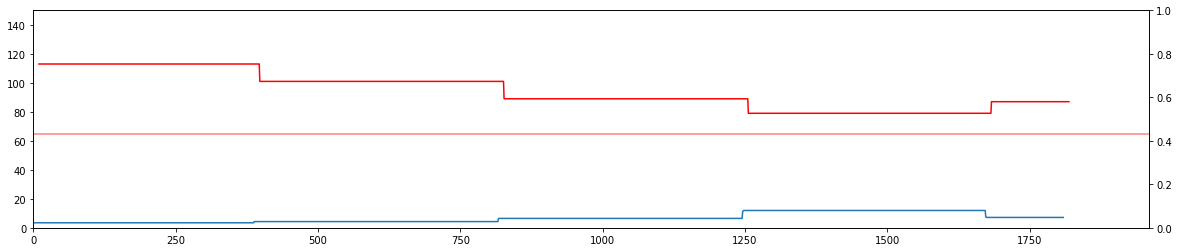

136/136 [==============================] - 3s 22ms/step
Print error: 5540	0.12643379949763395	


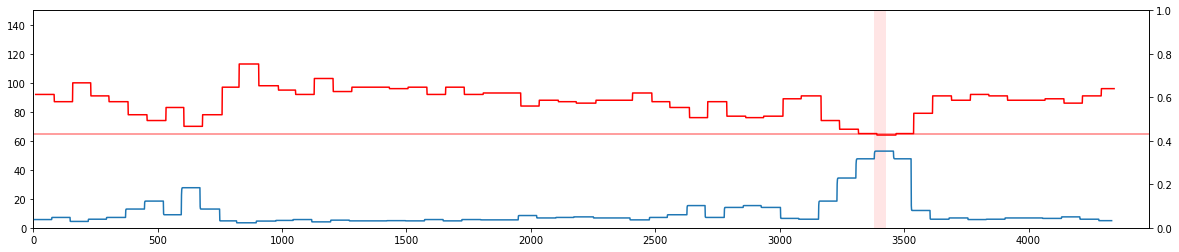

119/119 [==============================] - 2s 21ms/step
Print error: 5555	0.31242366096766405	


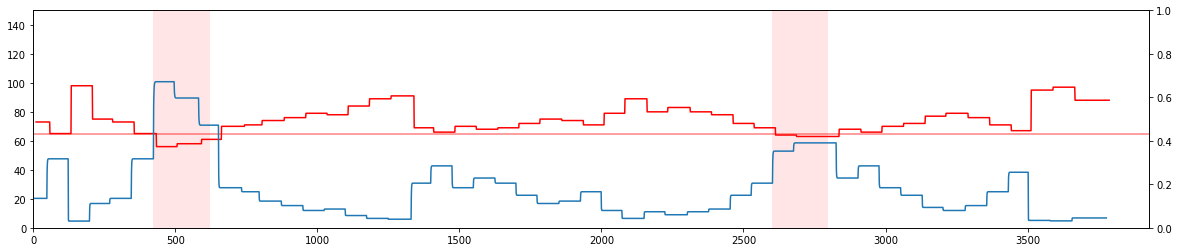

78/78 [==============================] - 2s 23ms/step
Print error: 5582	0.1531696976897332	


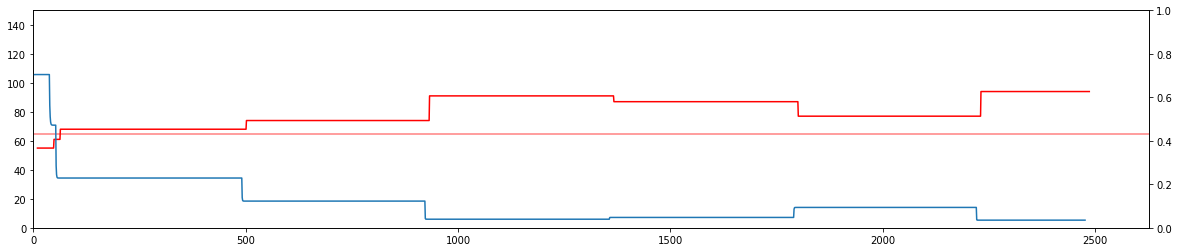

57/57 [==============================] - 1s 20ms/step
Print error: 5601	0.1598606230573618	


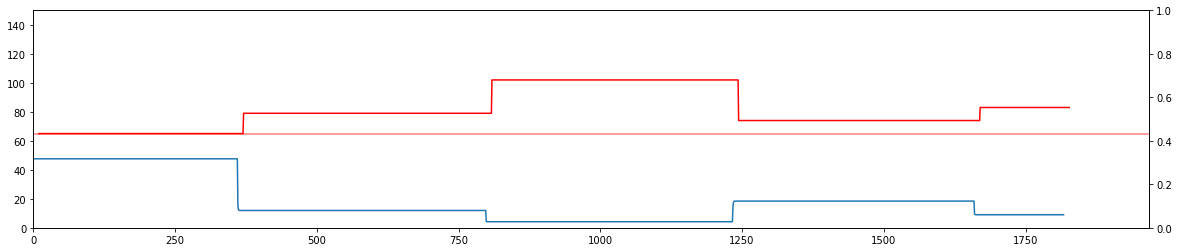

38/38 [==============================] - 1s 22ms/step
Print error: 5658	0.0972121631815136	


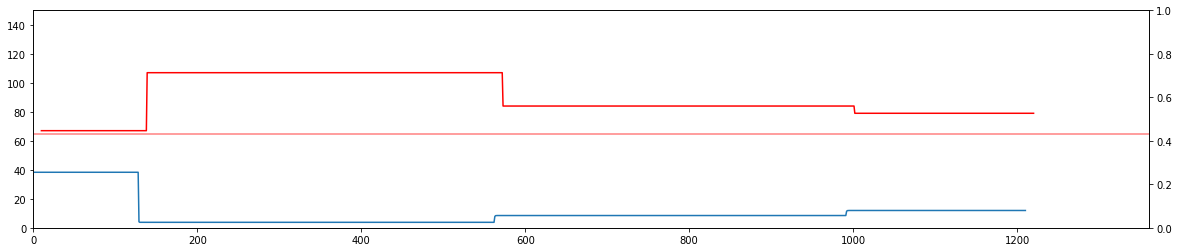

199/199 [==============================] - 5s 24ms/step
Print error: 5716	0.08222302091677941	


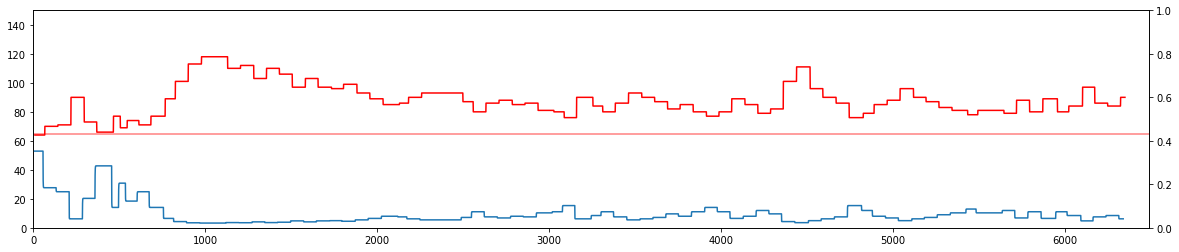

176/176 [==============================] - 5s 26ms/step
Print error: 5734	0.06620153610752791	


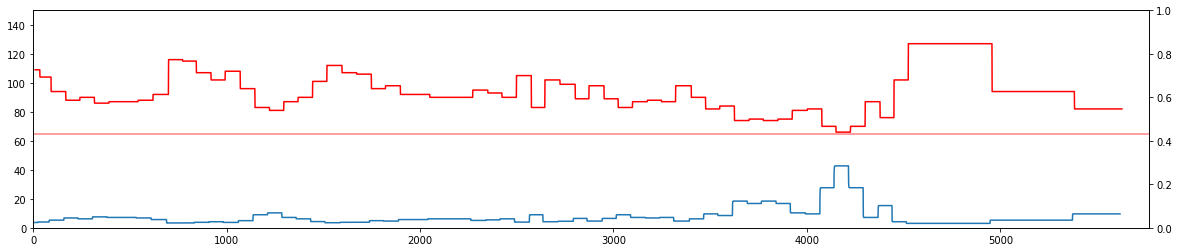

198/198 [==============================] - 5s 27ms/step
Print error: 5737	0.22766268732189618	


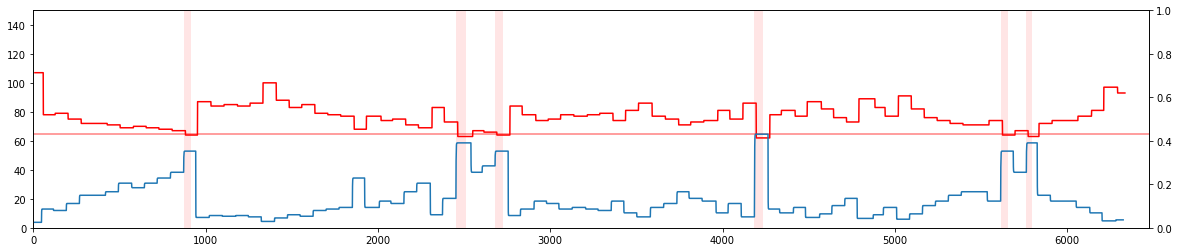

125/125 [==============================] - 4s 35ms/step
Print error: 5741	0.060713049670731	


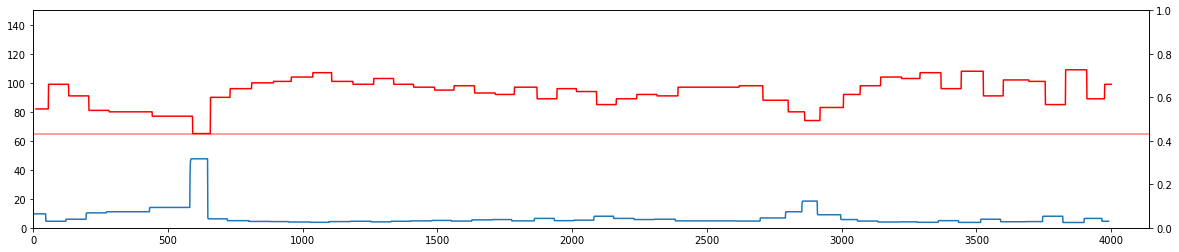

197/197 [==============================] - 7s 34ms/step
Print error: 5764	0.2881711413576794	


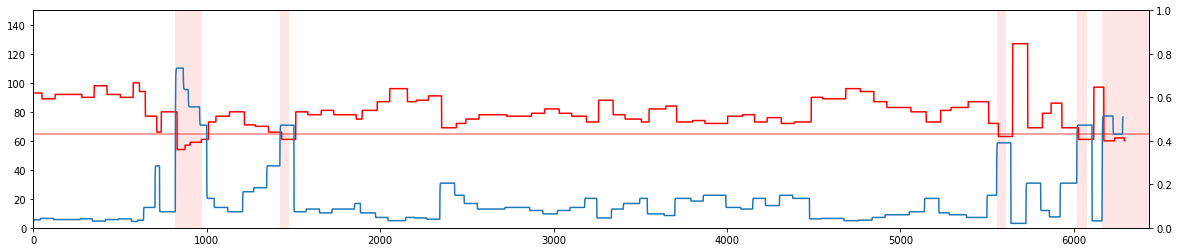

6/6 [==============================] - 0s 19ms/step
Print error: 5888	0.022768609827929144	


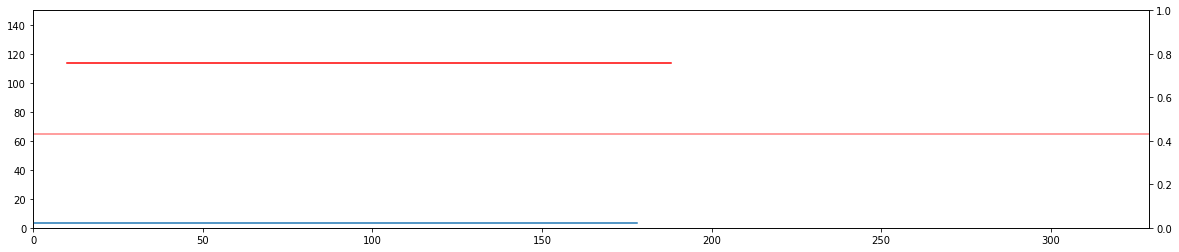

115/115 [==============================] - 3s 26ms/step
Print error: 5949	0.3167297687316952	


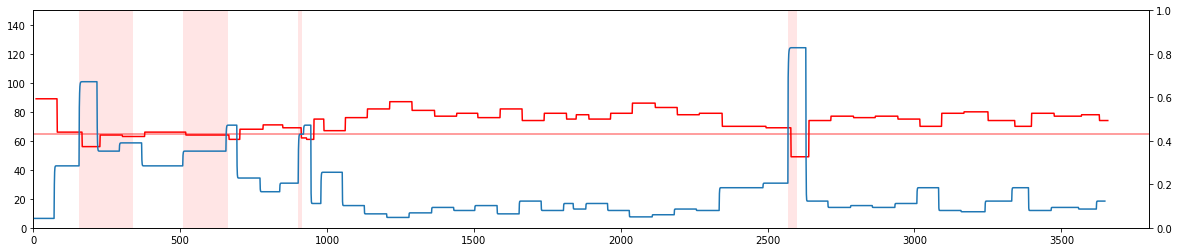

78/78 [==============================] - 3s 37ms/step
Print error: 6059	0.12005946082563362	


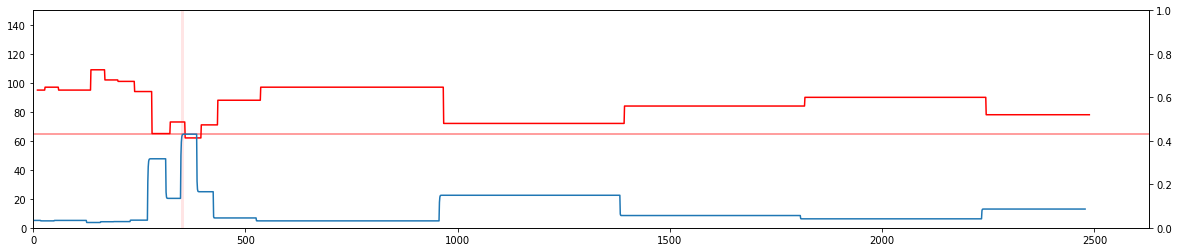

57/57 [==============================] - 2s 31ms/step
Print error: 6118	0.35052793655264614	


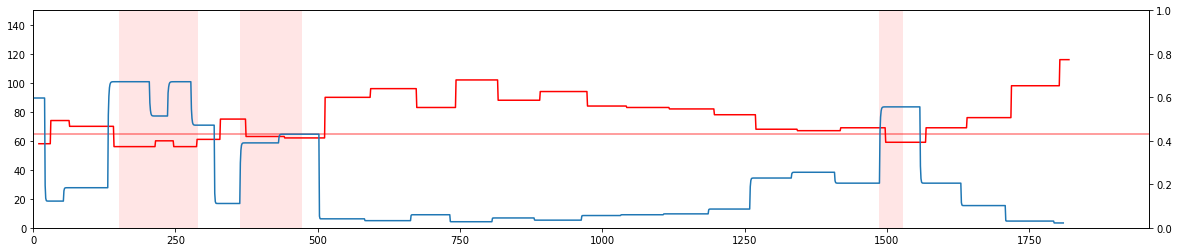

128/128 [==============================] - 4s 31ms/step
Print error: 6123	0.11195600532558667	


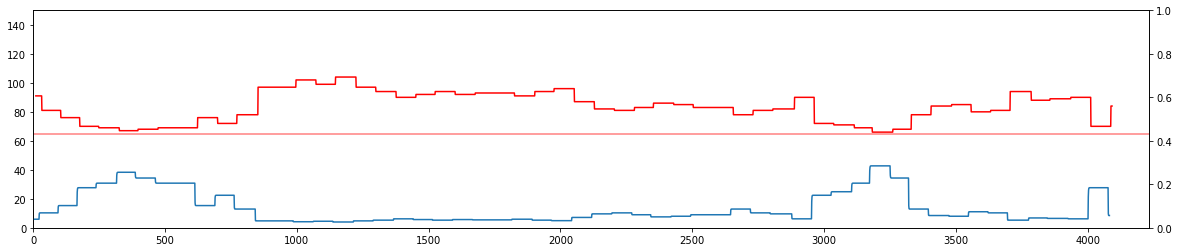

34/34 [==============================] - 1s 25ms/step
Print error: 6133	0.07841375750567602	


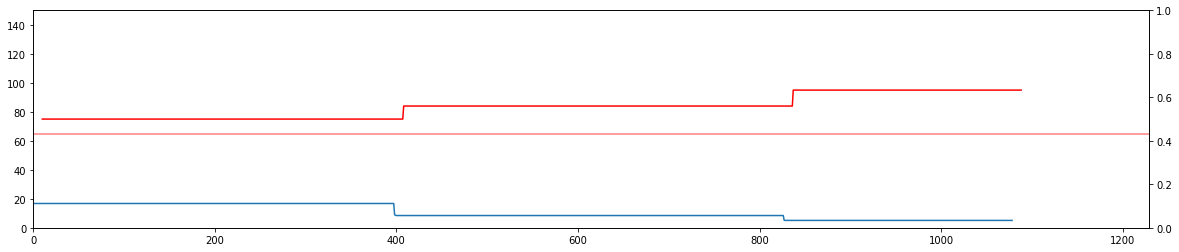

228/228 [==============================] - 6s 28ms/step
Print error: 6181	0.22542363062329807	


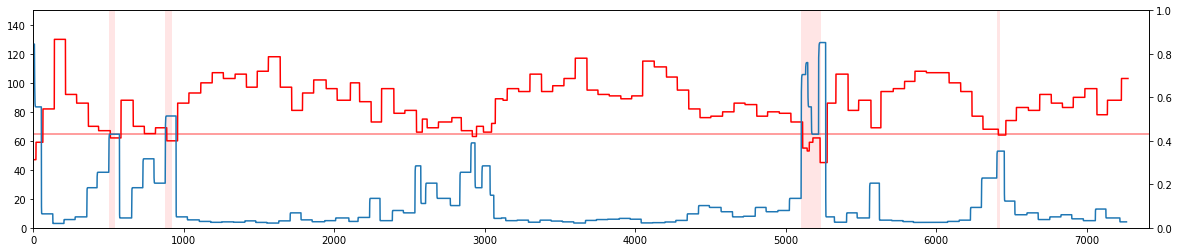

50/50 [==============================] - 1s 29ms/step
Print error: 6218	0.16062287645568998	


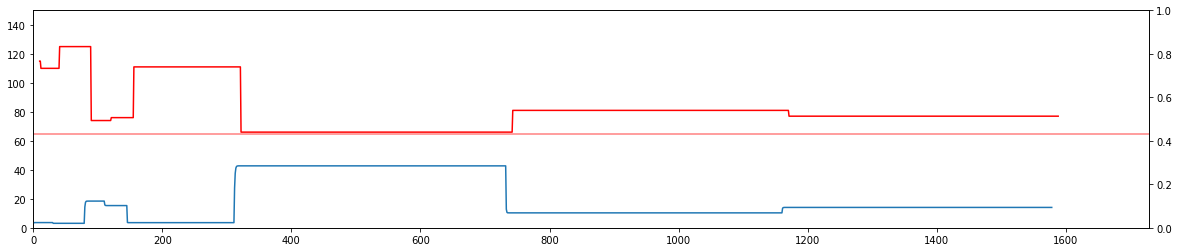

148/148 [==============================] - 5s 36ms/step
Print error: 6231	0.0908266752331756	


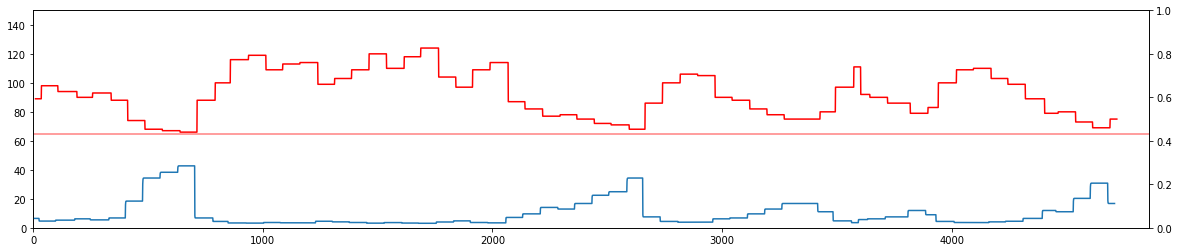

155/155 [==============================] - 5s 33ms/step
Print error: 6232	0.17065025292054228	


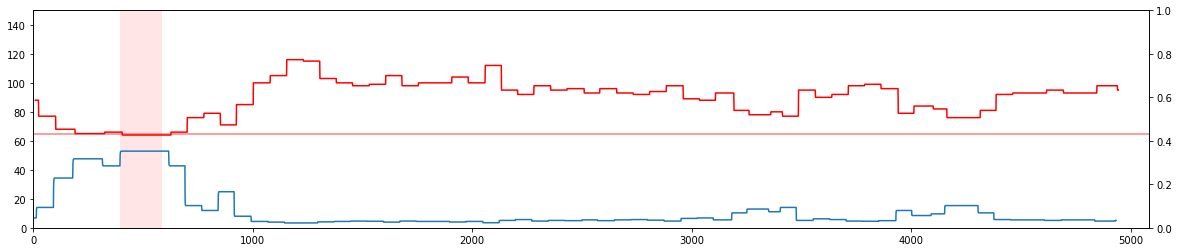

60/60 [==============================] - 2s 34ms/step
Print error: 6265	0.21568787943326637	


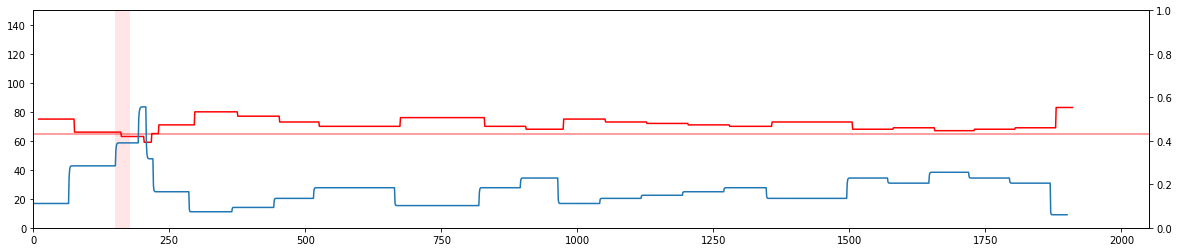

2/2 [==============================] - 0s 25ms/step
Print error: 6316	0.060051634625685434	


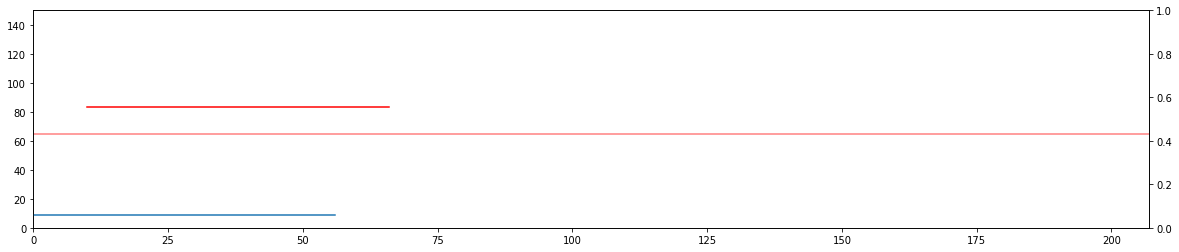

107/107 [==============================] - 3s 31ms/step
Print error: 6321	0.12497261239069143	


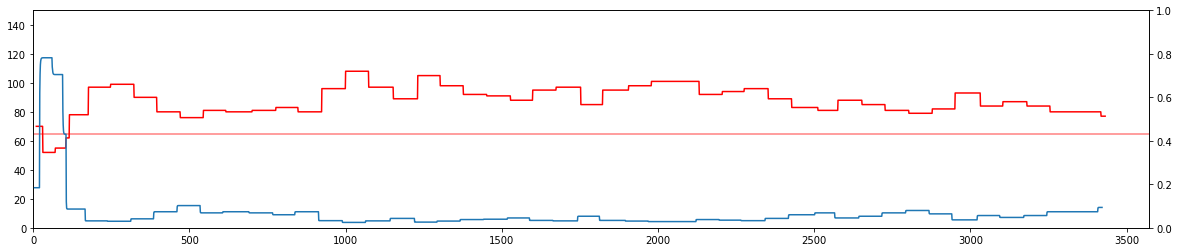

113/113 [==============================] - 4s 32ms/step
Print error: 6340	0.23675522948081612	


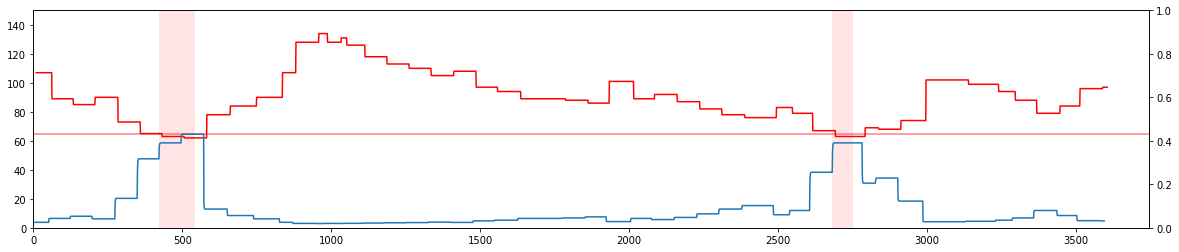

265/265 [==============================] - 8s 30ms/step
Print error: 6358	0.451874800532971	


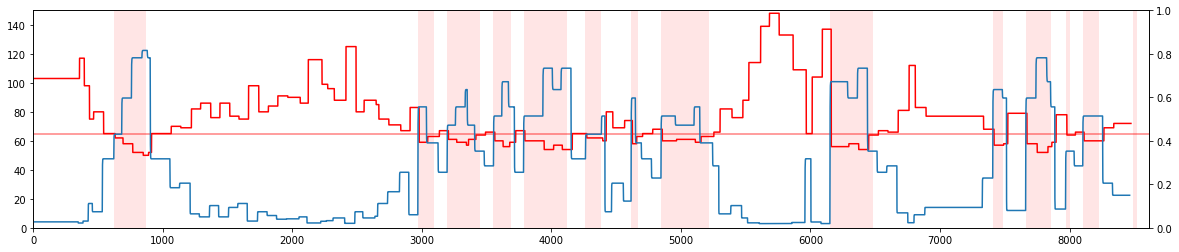

84/84 [==============================] - 2s 24ms/step
Print error: 6385	0.354170450957033	


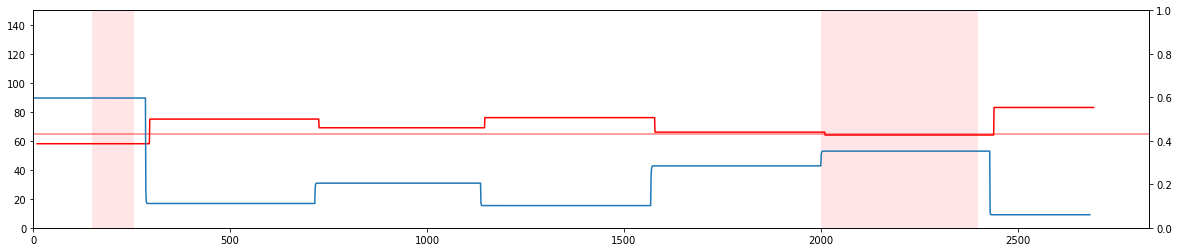

In [30]:
for caseid in caseids_test:
    case_mask = (c == caseid)
    case_len = np.sum(case_mask)
    if case_len == 0:
        continue

    case_x = x[case_mask]
    case_y = y[case_mask]
    case_valid_mask = valid_mask[case_mask]
    
    # calculate error for this case
    case_predy = model.predict(case_x).flatten()
    case_rmse = np.nanmean((case_y - case_predy) ** 2) ** 0.5
    print('Print error:', '{}\t{}\t'.format(caseid, case_rmse))

    # draw
    plt.figure(figsize=(20, 4))
    plt.xlim([0, case_len + MINUTES_AHEAD * 30])
    t = np.arange(0, case_len)

    # red bars for the event
    ax1 = plt.gca()
    for i in range(len(case_y)):
        if case_y[i]:
            ax1.axvspan(i + MINUTES_AHEAD * 30, i + MINUTES_AHEAD * 30 + 1, color='r', alpha=0.1, lw=0)

    # 65 mmHg bar
    ax1.axhline(y=65, color='r', alpha=0.5)
    ax1.plot(t + 10, case_x[:,-1], color='r')
    ax1.set_ylim([0, 150])

    ax2 = ax1.twinx()
    
    # draw valid samples
    case_predy[~case_valid_mask] = np.nan
    ax2.plot(t, case_predy)
    ax2.set_ylim([0, 1])
    
    # save
    plt.show()